**Precessing the BCC data based on AIRR standards**

- AirrCell formats reference: [AirrCell](https://scirpy.scverse.org/en/latest/tutorials/tutorial_io.html#creating-anndata-objects-from-other-formats)

- data download: [GSE123813](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE123813)
- data reference: [BCC reference](https://www.nature.com/articles/s41591-019-0522-3)
- description: BCC dataset contains pre-treatment and post-treatment data of 11 BCC patients, with paired TCR and GEX sequencing data. Sorted the cell into different cell types and different T cell subtypes.

**Guideline (user-defined dataset)**:
1. read the data and construct AirrCells
2. use scirpy to get the adata
3. filter cells and genes, select hvgs (Scanpy pipeline, without scaling across cells)
4. index chains, chain_qc, filter chains and EDA with scirpy
5. define clonotype with scirpy
6. tokenize the chains with esm tokenizer

In [1]:
import os,sys
sys.path.append(os.path.realpath(os.path.join(os.getcwd(), '..')))
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import scanpy as sc
import scirpy as ir
import pandas as pd
import numpy as np
from pathlib import Path
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=70)
sc.settings.n_jobs = 3
sc.set_figure_params(vector_friendly=True,color_map='viridis',dpi_save=300,transparent=True)

**1. Read the data and construct the AirrCell**

In [2]:
import vqtcr as vq
path_base = '/mnt/d/Dataset/MrTCR/BCC/'
path_merged = path_base + 'bcc_merged_airr.h5ad'

In [3]:
import pandas as pd
# read BCC metadata and tcell metadata
bcc_meta = pd.read_csv(path_base+'GSE123813_bcc_all_metadata.txt.gz', 
                      sep='\t', compression='gzip', index_col='cell.id')
bcc_tcell_meta = pd.read_csv(path_base+'GSE123813_bcc_tcell_metadata.txt.gz', 
                           sep='\t', compression='gzip', index_col='cell.id')

In [4]:
bcc_meta

,patient,treatment,sort,cluster,UMAP1,UMAP2
cell.id,,,,,,
bcc.su001.post.tcell_AAACCTGAGCTTCGCG,su001,post,CD45+ CD3+,CD8_mem_T_cells,-8.491220,5.533525
bcc.su001.post.tcell_AAACCTGAGGACATTA,su001,post,CD45+ CD3+,CD8_ex_T_cells,4.623724,6.668594
bcc.su001.post.tcell_AAACCTGCACGCATCG,su001,post,CD45+ CD3+,CD8_mem_T_cells,-7.920441,3.196553
bcc.su001.post.tcell_AAACCTGCAGATGGGT,su001,post,CD45+ CD3+,CD8_mem_T_cells,-7.878223,4.333302
bcc.su001.post.tcell_AAACCTGCAGTGGAGT,su001,post,CD45+ CD3+,Tregs,-2.382094,11.260816
...,...,...,...,...,...,...
bcc.su012.pre.tcell_TTTGGTTGTAGATTAG,su012,pre,CD45+ CD3+,Tregs,2.674866,11.652218
bcc.su012.pre.tcell_TTTGGTTGTCAAGCGA,su012,pre,CD45+ CD3+,CD8_mem_T_cells,-6.329399,5.186572
bcc.su012.pre.tcell_TTTGTCAAGAGGACGG,su012,pre,CD45+ CD3+,CD8_mem_T_cells,-8.817718,0.048990


In [5]:
bcc_tcell_meta

,patient,treatment,cluster,UMAP1,UMAP2
cell.id,,,,,
bcc.su001.post.tcell_AAACCTGAGCTTCGCG,su001,post,CD8_mem,7.621735,1.220029
bcc.su001.post.tcell_AAACCTGAGGACATTA,su001,post,Tfh,-3.826207,-2.074360
bcc.su001.post.tcell_AAACCTGCACGCATCG,su001,post,CD8_mem,7.182139,1.184734
bcc.su001.post.tcell_AAACCTGCAGATGGGT,su001,post,CD8_mem,7.229568,1.080957
bcc.su001.post.tcell_AAACCTGCAGTGGAGT,su001,post,Tregs,-5.315876,0.338287
...,...,...,...,...,...
bcc.su012.pre.tcell_TTTGGTTGTAGATTAG,su012,pre,Tregs,-6.709299,-0.328671
bcc.su012.pre.tcell_TTTGGTTGTCAAGCGA,su012,pre,CD8_mem,6.639210,1.112855
bcc.su012.pre.tcell_TTTGTCAAGAGGACGG,su012,pre,CD8_mem,6.311589,0.403260


In [6]:
bcc_tcell_meta['patient'].value_counts()

patient
su009    9047
su001    4959
su008    4868
su006    3805
su005    3464
su012    3301
su007    1668
su004     875
su010     626
su002     274
su003     219
Name: count, dtype: int64

In [7]:
df_gex = pd.read_csv(path_base+'GSE123813_bcc_scRNA_counts.txt.gz', sep="\t", index_col=0)
df_gex.head()

,bcc.su001.pre.tcell_AAACCTGCAGATCGGA,bcc.su001.pre.tcell_AAACCTGCAGGGATTG,bcc.su001.pre.tcell_AAACGGGCATAGACTC,bcc.su001.pre.tcell_AAACGGGTCATACGGT,bcc.su001.pre.tcell_AAACGGGTCATAGCAC,bcc.su001.pre.tcell_AAACGGGTCTTGGGTA,bcc.su001.pre.tcell_AAAGATGAGACAGGCT,bcc.su001.pre.tcell_AAAGATGCACAAGCCC,bcc.su001.pre.tcell_AAAGATGGTTTGGGCC,bcc.su001.pre.tcell_AAAGATGTCTGAGTGT,...,bcc.su012.post.tcell_TTTACTGGTCGGGTCT,bcc.su012.post.tcell_TTTACTGTCTTGCCGT,bcc.su012.post.tcell_TTTATGCAGCTAGCCC,bcc.su012.post.tcell_TTTATGCAGGCAGTCA,bcc.su012.post.tcell_TTTATGCCATATGGTC,bcc.su012.post.tcell_TTTGCGCGTCTTTCAT,bcc.su012.post.tcell_TTTGGTTCAGCCAGAA,bcc.su012.post.tcell_TTTGTCAAGCACCGTC,bcc.su012.post.tcell_TTTGTCAAGTGAACGC,bcc.su012.post.tcell_TTTGTCAGTCCCTTGT
FO538757.2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AP006222.2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RP11-206L10.9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
LINC00115,1,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0
FAM41C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
import scipy.sparse as sp
X = sp.csr_matrix(df_gex.values.T)
var = pd.DataFrame(index=df_gex.index)
obs = pd.DataFrame(index=df_gex.columns)

In [9]:
adata_gex = sc.AnnData(X=X, obs=obs, var=var)
adata_gex

AnnData object with n_obs × n_vars = 53030 × 23309

In [10]:
df_tcr = pd.read_csv(path_base+'GSE123813_bcc_tcr.txt.gz', sep="\t" , index_col=0)
df_tcr

,cdr3s_nt,cdr3s_aa
bcc.su001.pre.tcell_AAACCTGCAGATCGGA,TRB:TGCGCCAGCCGCCTAGCGGGGGGGCTCCAAGAGACCCAGTACTTC,TRB:CASRLAGGLQETQYF
bcc.su001.pre.tcell_AAACGGGTCATAGCAC,TRA:TGTGCAGAGACTATTTTGTACAGCAGTGCTTCCAAGATAATC...,TRA:CAETILYSSASKIIF;TRB:CAWTTPGTSNSPLHF
bcc.su001.pre.tcell_AAAGATGAGACAGGCT,TRA:TGCATCGTCAGTCTTTCTCTTGTGATTTATAACCAGGGAGGA...,TRA:CIVSLSLVIYNQGGKLIF;TRB:CASSSSWEGSPGEQYF
bcc.su001.pre.tcell_AAAGATGCACAAGCCC,TRA:TGTGCTGTGGAGCGAAATACTGGAGGCTTCAAAACTATCTTT...,TRA:CAVERNTGGFKTIF;TRB:CASSQLGNGNQPQHF
bcc.su001.pre.tcell_AAAGATGTCTGAGTGT,TRA:TGTGCTGGGGGGAATTATGGTGGTGCTACAAACAAGCTCATC...,TRA:CAGGNYGGATNKLIF;TRB:CASSLPGARVAFF
...,...,...
bcc.su012.post.tcell_TTTGCGCGTCTTTCAT,TRB:TGTGCCAGCAGCTTGCGACAGGGAGCTGGCAGCAATCAGCCC...,TRB:CASSLRQGAGSNQPQHF
bcc.su012.post.tcell_TTTGGTTCAGCCAGAA,TRA:TGTGCAGCAAGTGAAAACTACAAGCTCAGCTTT;TRB:TGTG...,TRA:CAASENYKLSF;TRB:CASSGEGRYGYTF
bcc.su012.post.tcell_TTTGTCAAGCACCGTC,TRA:TGTGCTGTGAGTACTAATGACATGCGCTTT;TRB:TGTGCCA...,TRA:CAVSTNDMRF;TRB:CASSPIGSYEQYF
bcc.su012.post.tcell_TTTGTCAAGTGAACGC,TRB:TGTGCCAGCAGTTTCCTCACAGGGGTCAACGAGCAGTACTTC,TRB:CASSFLTGVNEQYF


In [11]:
tcell_meta = bcc_tcell_meta.join(df_tcr, how='inner')
tcell_meta

,patient,treatment,cluster,UMAP1,UMAP2,cdr3s_nt,cdr3s_aa
bcc.su001.post.tcell_AAACCTGAGCTTCGCG,su001,post,CD8_mem,7.621735,1.220029,TRB:TGTGCCAGCAGCTCAGCAGGGGGCTTGAACACTGAAGCTTTC...,TRB:CASSSAGGLNTEAFF;TRB:CAWSVGPSSQGRYEQYF
bcc.su001.post.tcell_AAACCTGAGGACATTA,su001,post,Tfh,-3.826207,-2.074360,TRB:TGTGCCAGCAGCGTAGAAATAGGGATCGGCTACACCTTC,TRB:CASSVEIGIGYTF
bcc.su001.post.tcell_AAACCTGCACGCATCG,su001,post,CD8_mem,7.182139,1.184734,TRB:TGTGCCAGCAGCCTTAGCGGGGGGAGCTCCTACAATGAGCAG...,TRB:CASSLSGGSSYNEQFF
bcc.su001.post.tcell_AAACCTGCAGATGGGT,su001,post,CD8_mem,7.229568,1.080957,TRB:TGTGCCAGCAGCTTAGACCACGGGACAGGGGGCTTTAACACC...,TRB:CASSLDHGTGGFNTGELFF
bcc.su001.post.tcell_AAACCTGCAGTGGAGT,su001,post,Tregs,-5.315876,0.338287,TRA:TGTGCAGATGCTGGTGGTACTAGCTATGGAAAGCTGACATTT,TRA:CADAGGTSYGKLTF
...,...,...,...,...,...,...,...
bcc.su012.pre.tcell_TTTGGTTCACCATCCT,su012,pre,Th17,-3.715483,5.135968,TRA:TGCATCGTCAGAAATAACAATGCCAGACTCATGTTT;TRB:T...,TRA:CIVRNNNARLMF;TRB:CASSFPGTSGRGEQYF
bcc.su012.pre.tcell_TTTGGTTCAGGTGGAT,su012,pre,CD8_mem,6.309550,0.174888,TRA:TGTGCCGTTCAGGGAGGAAAGCTTATCTTC;TRB:TGCAGCG...,TRA:CAVQGGKLIF;TRB:CSVEDSVAGNGYTF
bcc.su012.pre.tcell_TTTGGTTGTAGATTAG,su012,pre,Tregs,-6.709299,-0.328671,TRA:TGTGCTCTAGAGAAATCGCAAGGTGGCTACAATAAGCTGATT...,TRA:CALEKSQGGYNKLIF;TRB:CASRLFSGNTIYF
bcc.su012.pre.tcell_TTTGTCAAGAGGACGG,su012,pre,CD8_mem,6.311589,0.403260,TRA:TGCATCCTGTCGGAAGACACCGGTAACCAGTTCTATTTT;TR...,TRA:CILSEDTGNQFYF;TRB:CASSSGQKNSPLHF


In [12]:
meta_data = bcc_meta.join(tcell_meta, how='inner', rsuffix='_tcell')
meta_data


,patient,treatment,sort,cluster,UMAP1,UMAP2,patient_tcell,treatment_tcell,cluster_tcell,UMAP1_tcell,UMAP2_tcell,cdr3s_nt,cdr3s_aa
bcc.su001.post.tcell_AAACCTGAGCTTCGCG,su001,post,CD45+ CD3+,CD8_mem_T_cells,-8.491220,5.533525,su001,post,CD8_mem,7.621735,1.220029,TRB:TGTGCCAGCAGCTCAGCAGGGGGCTTGAACACTGAAGCTTTC...,TRB:CASSSAGGLNTEAFF;TRB:CAWSVGPSSQGRYEQYF
bcc.su001.post.tcell_AAACCTGAGGACATTA,su001,post,CD45+ CD3+,CD8_ex_T_cells,4.623724,6.668594,su001,post,Tfh,-3.826207,-2.074360,TRB:TGTGCCAGCAGCGTAGAAATAGGGATCGGCTACACCTTC,TRB:CASSVEIGIGYTF
bcc.su001.post.tcell_AAACCTGCACGCATCG,su001,post,CD45+ CD3+,CD8_mem_T_cells,-7.920441,3.196553,su001,post,CD8_mem,7.182139,1.184734,TRB:TGTGCCAGCAGCCTTAGCGGGGGGAGCTCCTACAATGAGCAG...,TRB:CASSLSGGSSYNEQFF
bcc.su001.post.tcell_AAACCTGCAGATGGGT,su001,post,CD45+ CD3+,CD8_mem_T_cells,-7.878223,4.333302,su001,post,CD8_mem,7.229568,1.080957,TRB:TGTGCCAGCAGCTTAGACCACGGGACAGGGGGCTTTAACACC...,TRB:CASSLDHGTGGFNTGELFF
bcc.su001.post.tcell_AAACCTGCAGTGGAGT,su001,post,CD45+ CD3+,Tregs,-2.382094,11.260816,su001,post,Tregs,-5.315876,0.338287,TRA:TGTGCAGATGCTGGTGGTACTAGCTATGGAAAGCTGACATTT,TRA:CADAGGTSYGKLTF
...,...,...,...,...,...,...,...,...,...,...,...,...,...
bcc.su012.pre.tcell_TTTGGTTCACCATCCT,su012,pre,CD45+ CD3+,CD4_T_cells,-0.827652,7.133596,su012,pre,Th17,-3.715483,5.135968,TRA:TGCATCGTCAGAAATAACAATGCCAGACTCATGTTT;TRB:T...,TRA:CIVRNNNARLMF;TRB:CASSFPGTSGRGEQYF
bcc.su012.pre.tcell_TTTGGTTCAGGTGGAT,su012,pre,CD45+ CD3+,CD8_mem_T_cells,-8.183326,1.400621,su012,pre,CD8_mem,6.309550,0.174888,TRA:TGTGCCGTTCAGGGAGGAAAGCTTATCTTC;TRB:TGCAGCG...,TRA:CAVQGGKLIF;TRB:CSVEDSVAGNGYTF
bcc.su012.pre.tcell_TTTGGTTGTAGATTAG,su012,pre,CD45+ CD3+,Tregs,2.674866,11.652218,su012,pre,Tregs,-6.709299,-0.328671,TRA:TGTGCTCTAGAGAAATCGCAAGGTGGCTACAATAAGCTGATT...,TRA:CALEKSQGGYNKLIF;TRB:CASRLFSGNTIYF
bcc.su012.pre.tcell_TTTGTCAAGAGGACGG,su012,pre,CD45+ CD3+,CD8_mem_T_cells,-8.817718,0.048990,su012,pre,CD8_mem,6.311589,0.403260,TRA:TGCATCCTGTCGGAAGACACCGGTAACCAGTTCTATTTT;TR...,TRA:CILSEDTGNQFYF;TRB:CASSSGQKNSPLHF


In [13]:
common = adata_gex.obs_names.intersection(meta_data.index.astype(str))
adata_tmp = adata_gex[common].copy()
adata_tmp

AnnData object with n_obs × n_vars = 28371 × 23309

In [14]:
adata_tmp.obs = adata_tmp.obs.join(meta_data.loc[common], how="left")
adata_tmp

AnnData object with n_obs × n_vars = 28371 × 23309
    obs: 'patient', 'treatment', 'sort', 'cluster', 'UMAP1', 'UMAP2', 'patient_tcell', 'treatment_tcell', 'cluster_tcell', 'UMAP1_tcell', 'UMAP2_tcell', 'cdr3s_nt', 'cdr3s_aa'

In [15]:
sc.pp.filter_genes(adata_tmp, min_counts=1)
adata_tmp

filtered out 5287 genes that are detected in less than 1 counts


AnnData object with n_obs × n_vars = 28371 × 18022
    obs: 'patient', 'treatment', 'sort', 'cluster', 'UMAP1', 'UMAP2', 'patient_tcell', 'treatment_tcell', 'cluster_tcell', 'UMAP1_tcell', 'UMAP2_tcell', 'cdr3s_nt', 'cdr3s_aa'
    var: 'n_counts'

In [16]:
tcell_meta = tcell_meta.reset_index(names='cell_id')

In [17]:
def _split_locus_seq(s):
    if pd.isna(s) or not isinstance(s, str) or s.strip() == "":
        return []
    out = []
    for p in s.split(";"):
        p = p.strip()
        if not p:
            continue
        if ':' in p:
            locus, seq = p.split(':', 1)
            locus = locus.strip().upper()
            seq = seq.strip()
            if locus in {'TRA', 'TRB'} and seq:
                out.append((locus, seq))
    return out

def build_airr_cells(tcell_meta, cell_col="cell_id", aa_col="cdr3s_aa", nt_col="cdr3s_nt"):
    airr_cells = []
    for _, row in tcell_meta.iterrows():
        cid = str(row[cell_col])
        cell = ir.io.AirrCell(cell_id=cid)
        aa_pairs = _split_locus_seq(row.get(aa_col, np.nan))
        nt_pairs = _split_locus_seq(row.get(nt_col, np.nan))
        aa_map = {"TRA": [], "TRB": []}
        nt_map = {"TRA": [], "TRB": []}
        for locus, seq in aa_pairs:
            aa_map[locus].append(seq)
        for locus, seq in nt_pairs:
            nt_map[locus].append(seq)
        for locus in ("TRA", "TRB"):
            n = max(len(aa_map[locus]), len(nt_map[locus]))
            for i in range(n):
                ch = ir.io.AirrCell.empty_chain_dict()  
                ch.update({
                    "locus": locus,   
                    "junction_aa": aa_map[locus][i] if i < len(aa_map[locus]) else np.nan,
                    "junction":    nt_map[locus][i] if i < len(nt_map[locus]) else np.nan,
                    # optional
                    "productive": True,         
                    "umi_count":  np.nan,
                    "v_call":     np.nan,
                    "j_call":     np.nan,
                    "d_call":     np.nan,
                })
                if pd.isna(ch["junction_aa"]) and pd.isna(ch["junction"]):
                    continue
                cell.add_chain(ch)

        airr_cells.append(cell)
    return airr_cells

In [18]:
cells = build_airr_cells(tcell_meta)
len(cells)

/home/zl/anaconda3/envs/airr/lib/python3.10/site-packages/airr/schema.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream


28371

**2. use scirpy to get the adata**

In [19]:
adata_airr = ir.io.from_airr_cells(cells)

/home/zl/anaconda3/envs/airr/lib/python3.10/site-packages/anndata/utils.py:354: ExperimentalFeatureWarning: Support for Awkward Arrays is currently experimental. Behavior may change in the future. Please report any issues you may encounter!
  warnings.warn(msg, category, stacklevel=stacklevel)


In [20]:
barcode2idx = {barcode: i for i, barcode in enumerate(adata_airr.obs_names)}
idx = [barcode2idx.get(barcode) for barcode in adata_tmp.obs_names]

adata_tmp.obsm['airr'] = adata_airr.obsm['airr'][idx]
adata_tmp

AnnData object with n_obs × n_vars = 28371 × 18022
    obs: 'patient', 'treatment', 'sort', 'cluster', 'UMAP1', 'UMAP2', 'patient_tcell', 'treatment_tcell', 'cluster_tcell', 'UMAP1_tcell', 'UMAP2_tcell', 'cdr3s_nt', 'cdr3s_aa'
    var: 'n_counts'
    obsm: 'airr'

**3. filter cells and genes, select hvgs**

In [21]:
import awkward as ak
adata_tmp = adata_tmp[~ak.is_none(adata_tmp.obsm['airr']).to_numpy()]
adata_tmp

View of AnnData object with n_obs × n_vars = 28371 × 18022
    obs: 'patient', 'treatment', 'sort', 'cluster', 'UMAP1', 'UMAP2', 'patient_tcell', 'treatment_tcell', 'cluster_tcell', 'UMAP1_tcell', 'UMAP2_tcell', 'cdr3s_nt', 'cdr3s_aa'
    var: 'n_counts'
    obsm: 'airr'

In [22]:
sc.pp.normalize_total(adata_tmp, target_sum=1e4)
sc.pp.log1p(adata_tmp)
sc.pp.highly_variable_genes(adata_tmp, n_top_genes=5000)
adata_tmp = adata_tmp[:, adata_tmp.var['highly_variable']]
adata_tmp

/home/zl/anaconda3/envs/airr/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


View of AnnData object with n_obs × n_vars = 28371 × 5000
    obs: 'patient', 'treatment', 'sort', 'cluster', 'UMAP1', 'UMAP2', 'patient_tcell', 'treatment_tcell', 'cluster_tcell', 'UMAP1_tcell', 'UMAP2_tcell', 'cdr3s_nt', 'cdr3s_aa'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'airr'

**4. index chains, chain_qc, filter chains and EDA with scirpy**

In [23]:
ir.pp.index_chains(adata_tmp)
ir.tl.chain_qc(adata_tmp)
adata_tmp

Filtering chains...
Indexing VJ chains...
Indexing VDJ chains...
build result array


/home/zl/anaconda3/envs/airr/lib/python3.10/site-packages/scirpy/pp/_index_chains.py:142: ImplicitModificationWarning: Setting element `.obsm['chain_indices']` of view, initializing view as actual.
  params.adata.obsm[key_added] = ak.zip(res, depth_limit=1)  # type: ignore


Stored result in `adata.obs["receptor_type"]`.
Stored result in `adata.obs["receptor_subtype"]`.
Stored result in `adata.obs["chain_pairing"]`.


AnnData object with n_obs × n_vars = 28371 × 5000
    obs: 'patient', 'treatment', 'sort', 'cluster', 'UMAP1', 'UMAP2', 'patient_tcell', 'treatment_tcell', 'cluster_tcell', 'UMAP1_tcell', 'UMAP2_tcell', 'cdr3s_nt', 'cdr3s_aa', 'receptor_type', 'receptor_subtype', 'chain_pairing'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'chain_indices'
    obsm: 'airr', 'chain_indices'

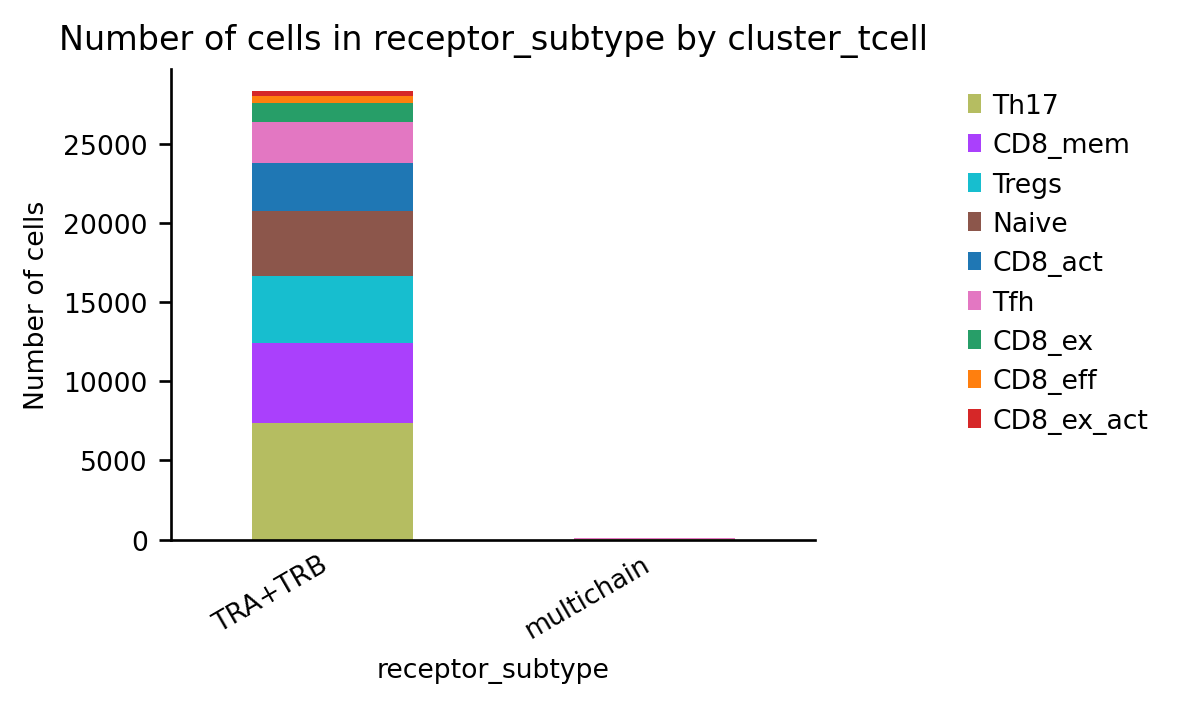

In [24]:
_ = ir.pl.group_abundance(adata_tmp, groupby="receptor_subtype", target_col="cluster_tcell")

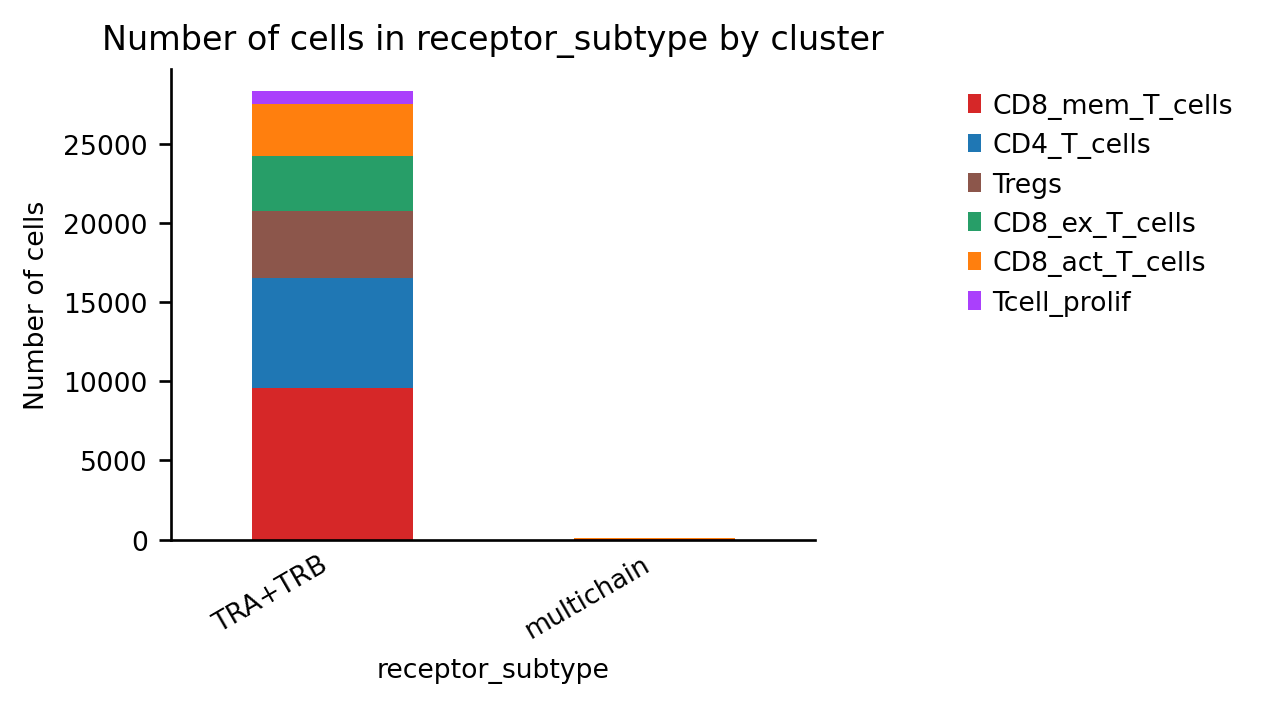

In [25]:
_ = ir.pl.group_abundance(adata_tmp, groupby="receptor_subtype", target_col="cluster")

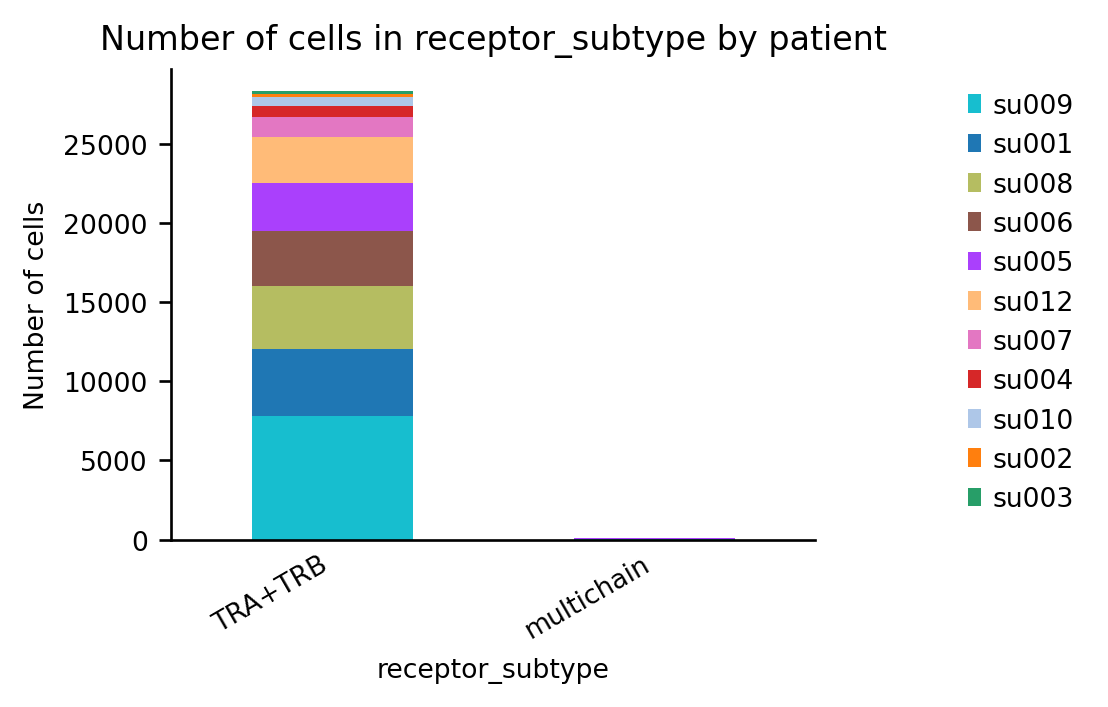

In [26]:
_ = ir.pl.group_abundance(adata_tmp, groupby="receptor_subtype", target_col="patient")

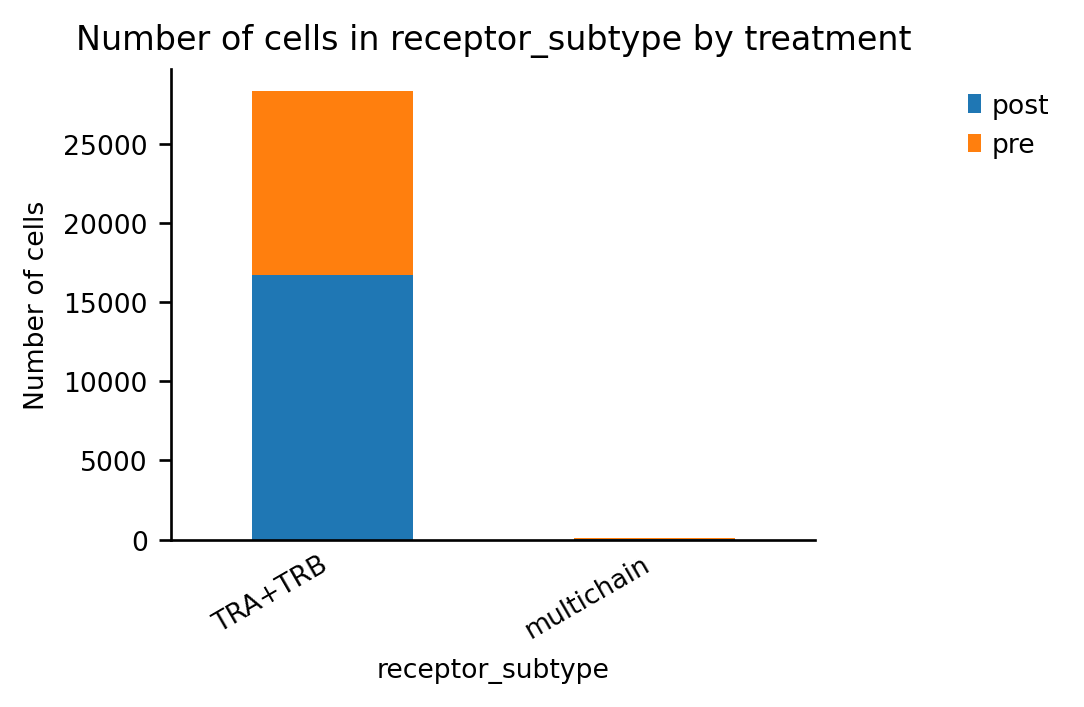

In [27]:
_ = ir.pl.group_abundance(adata_tmp, groupby="receptor_subtype", target_col="treatment")

In [28]:
adata_tmp.obs.cluster.value_counts()
adata_tmp.obs.cluster_tcell.value_counts()
pd.crosstab(adata_tmp.obs["cluster"], adata_tmp.obs["cluster_tcell"])

cluster_tcell,CD8_act,CD8_eff,CD8_ex,CD8_ex_act,CD8_mem,Naive,Tfh,Th17,Tregs
cluster,,,,,,,,,
CD4_T_cells,77,0,1,0,74,220,91,6415,87
CD8_act_T_cells,2850,18,11,274,40,33,62,16,9
CD8_ex_T_cells,1,0,1026,1,20,67,2233,83,20
CD8_mem_T_cells,94,453,79,2,4849,3770,39,279,24
Tcell_prolif,15,0,53,5,79,40,60,479,75
Tregs,11,1,20,1,8,11,80,127,3988


In [29]:
adata_tmp = adata_tmp[adata_tmp.obs["chain_pairing"] == "single pair", :]
adata_tmp

View of AnnData object with n_obs × n_vars = 17245 × 5000
    obs: 'patient', 'treatment', 'sort', 'cluster', 'UMAP1', 'UMAP2', 'patient_tcell', 'treatment_tcell', 'cluster_tcell', 'UMAP1_tcell', 'UMAP2_tcell', 'cdr3s_nt', 'cdr3s_aa', 'receptor_type', 'receptor_subtype', 'chain_pairing'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'chain_indices', 'cluster_tcell_colors', 'cluster_colors', 'patient_colors', 'treatment_colors'
    obsm: 'airr', 'chain_indices'

**5. define clonotype with scirpy**
- prepare `.obs` with clonetype, clone_id, alpha chain, beta chain, antigen...

In [30]:
adata = adata_tmp.copy()

In [31]:
ir.pp.ir_dist(adata)
ir.tl.define_clonotypes(adata, key_added='clonotype', receptor_arms='all', dual_ir='primary_only')
adata

Computing sequence x sequence distance matrix for VJ sequences.
Computing sequence x sequence distance matrix for VDJ sequences.
Initializing lookup tables. 
--> Done initializing lookup tables. (0:00:00)
Computing clonotype x clonotype distances.
--> Done computing clonotype x clonotype distances.  (0:00:00)
Stored result in `adata.obs["clonotype"]`.
Stored result in `adata.obs["clonotype_size"]`.


AnnData object with n_obs × n_vars = 17245 × 5000
    obs: 'patient', 'treatment', 'sort', 'cluster', 'UMAP1', 'UMAP2', 'patient_tcell', 'treatment_tcell', 'cluster_tcell', 'UMAP1_tcell', 'UMAP2_tcell', 'cdr3s_nt', 'cdr3s_aa', 'receptor_type', 'receptor_subtype', 'chain_pairing', 'clonotype', 'clonotype_size'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'chain_indices', 'cluster_tcell_colors', 'cluster_colors', 'patient_colors', 'treatment_colors', 'ir_dist_nt_identity', 'clonotype'
    obsm: 'airr', 'chain_indices'

In [32]:
adata.obs["clonotype"].value_counts()

clonotype
6771    298
6802     98
6776     76
8900     73
2356     53
       ... 
3629      1
3630      1
3631      1
3632      1
3622      1
Name: count, Length: 10001, dtype: int64

**6. tokenize the chains with esm tokenizer**

In [33]:
junction_aa = ir.get.airr(adata, 'junction_aa')
junction_aa

,VJ_1_junction_aa,VDJ_1_junction_aa,VJ_2_junction_aa,VDJ_2_junction_aa
bcc.su001.pre.tcell_AAACGGGTCATAGCAC,CAETILYSSASKIIF,CAWTTPGTSNSPLHF,None,None
bcc.su001.pre.tcell_AAAGATGAGACAGGCT,CIVSLSLVIYNQGGKLIF,CASSSSWEGSPGEQYF,None,None
bcc.su001.pre.tcell_AAAGATGCACAAGCCC,CAVERNTGGFKTIF,CASSQLGNGNQPQHF,None,None
bcc.su001.pre.tcell_AAAGATGTCTGAGTGT,CAGGNYGGATNKLIF,CASSLPGARVAFF,None,None
bcc.su001.pre.tcell_AAAGCAAAGAGTTGGC,CAMRDTGNQFYF,CASSLETGPETQYF,None,None
...,...,...,...,...
bcc.su012.post.tcell_TTTACTGAGCTCCTTC,CALSGSGYSTLTF,CASSYAPQGRIVETQYF,None,None
bcc.su012.post.tcell_TTTATGCCATATGGTC,CIVRVRGNAGNMLTF,CASSLVGRGDEQFF,None,None
bcc.su012.post.tcell_TTTGGTTCAGCCAGAA,CAASENYKLSF,CASSGEGRYGYTF,None,None
bcc.su012.post.tcell_TTTGTCAAGCACCGTC,CAVSTNDMRF,CASSPIGSYEQYF,None,None


In [34]:
adata.obs['VJ_1_junction_aa'] = junction_aa['VJ_1_junction_aa']
adata.obs['VDJ_1_junction_aa'] = junction_aa['VDJ_1_junction_aa']
adata.obs['VJ_1_junction_aa'], adata.obs['VDJ_1_junction_aa']

(bcc.su001.pre.tcell_AAACGGGTCATAGCAC        CAETILYSSASKIIF
 bcc.su001.pre.tcell_AAAGATGAGACAGGCT     CIVSLSLVIYNQGGKLIF
 bcc.su001.pre.tcell_AAAGATGCACAAGCCC         CAVERNTGGFKTIF
 bcc.su001.pre.tcell_AAAGATGTCTGAGTGT        CAGGNYGGATNKLIF
 bcc.su001.pre.tcell_AAAGCAAAGAGTTGGC           CAMRDTGNQFYF
                                                 ...        
 bcc.su012.post.tcell_TTTACTGAGCTCCTTC         CALSGSGYSTLTF
 bcc.su012.post.tcell_TTTATGCCATATGGTC       CIVRVRGNAGNMLTF
 bcc.su012.post.tcell_TTTGGTTCAGCCAGAA           CAASENYKLSF
 bcc.su012.post.tcell_TTTGTCAAGCACCGTC            CAVSTNDMRF
 bcc.su012.post.tcell_TTTGTCAGTCCCTTGT         CAFIALNNNDMRF
 Name: VJ_1_junction_aa, Length: 17245, dtype: object,
 bcc.su001.pre.tcell_AAACGGGTCATAGCAC       CAWTTPGTSNSPLHF
 bcc.su001.pre.tcell_AAAGATGAGACAGGCT      CASSSSWEGSPGEQYF
 bcc.su001.pre.tcell_AAAGATGCACAAGCCC       CASSQLGNGNQPQHF
 bcc.su001.pre.tcell_AAAGATGTCTGAGTGT         CASSLPGARVAFF
 bcc.su001.pre.tcell_AAAGCAAAGAGTT

In [35]:
adata.obs['alpha_len'] = junction_aa.VJ_1_junction_aa.str.len().values
adata.obs['beta_len'] = junction_aa.VDJ_1_junction_aa.str.len().values
len_alpha = junction_aa.VJ_1_junction_aa.str.len().max()
len_beta = junction_aa.VDJ_1_junction_aa.str.len().max()
pad_len = max(len_alpha, len_beta)
len_alpha, len_beta, pad_len

(np.int64(25), np.int64(23), np.int64(25))

In [36]:
vq.aa_tokenizer(adata, 
                esm_type='facebook/esm2_t6_8M_UR50D',
                read_col='VJ_1_junction_aa',
                label_col='alpha_seq',
                length_col='alpha_len', 
                mask_col='alpha_mask', 
                pad=pad_len, 
                add_special_tokens=False)
vq.aa_tokenizer(adata, 
                esm_type='facebook/esm2_t6_8M_UR50D',
                read_col='VDJ_1_junction_aa',
                label_col='beta_seq',
                length_col='beta_len', 
                mask_col='beta_mask', 
                pad=pad_len, 
                add_special_tokens=False)
adata

AnnData object with n_obs × n_vars = 17245 × 5000
    obs: 'patient', 'treatment', 'sort', 'cluster', 'UMAP1', 'UMAP2', 'patient_tcell', 'treatment_tcell', 'cluster_tcell', 'UMAP1_tcell', 'UMAP2_tcell', 'cdr3s_nt', 'cdr3s_aa', 'receptor_type', 'receptor_subtype', 'chain_pairing', 'clonotype', 'clonotype_size', 'VJ_1_junction_aa', 'VDJ_1_junction_aa', 'alpha_len', 'beta_len'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'chain_indices', 'cluster_tcell_colors', 'cluster_colors', 'patient_colors', 'treatment_colors', 'ir_dist_nt_identity', 'clonotype'
    obsm: 'airr', 'chain_indices', 'alpha_seq', 'alpha_mask', 'beta_seq', 'beta_mask'

- save to `h5ad` file

In [37]:
adata.write_h5ad(path_merged, compression='gzip')

: 